In [2]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt




In [3]:
def my_svd(C: np.array, eps_rank: float = 1, zero_tol: float = 1e-8, n_vecs: int = 0) -> np.array:
    U,S,Vh = np.linalg.svd(C, full_matrices=True)

    if n_vecs > 0:
        U = U[:,:n_vecs]
        S = S[:n_vecs]
        Vh = Vh[:n_vecs]

    else:
        nnz_ids = ~np.isclose(S, 0, atol=zero_tol)
        U = U[:,:len(S)][:,nnz_ids]
        S = S[nnz_ids]
        Vh = Vh[nnz_ids,:]

        s_prop = np.cumsum(S**2)/np.sum(S**2)
        good_idx = s_prop<=eps_rank
        U = U[:,good_idx]
        S = S[good_idx]
        Vh = Vh[good_idx,:]

    return U, S, Vh

In [4]:
n = 10
p = 7

hidden_flag_type = [2,4]

hidden_ms = [2,2]
col_ids = [3,4]

np.random.seed(42)


D = []
for i in range(len(hidden_flag_type)):
    # Set dimensions
    rows = n
    cols = col_ids[i]

    # Generate a random matrix of rank < cols
    # First, create a matrix of lower rank (rank < cols)
    rank = hidden_ms[i] # Specify the desired rank
    low_rank_matrix = np.random.randn(rows, rank)

    if i > 0:
        # Multiply by another random matrix to get the final matrix with more columns
        random_matrix = (np.eye(n) - random_matrix @np.linalg.pinv(random_matrix.T @ random_matrix) @ random_matrix.T) @ low_rank_matrix @ np.random.randn(rank, cols)
    else:
        random_matrix =  low_rank_matrix @ np.random.randn(rank, cols)

    # Verify the rank of the matrix
    rank_of_matrix = np.linalg.matrix_rank(random_matrix)
    print(f'matrix rank is {rank_of_matrix}')

    D.append(random_matrix)

D = np.hstack(D)
print(D.shape)
print(f'total shape is {D.shape}, total rank is {np.linalg.matrix_rank(D)}')

matrix rank is 2
matrix rank is 2
(10, 7)
total shape is (10, 7), total rank is 4


In [5]:
np.linalg.matrix_rank(D[:,:3])

np.int64(2)

In [6]:
for i in range(1,p):
    print([i,p])
    As = [np.arange(i), np.arange(p)]

    my_flag_rep = FlagRep(Aset = As)
    X = my_flag_rep.fit_transform(D)
    D_out0 = my_flag_rep.inverse_transform(X)
    print(f'FlagRep err: {np.linalg.norm(D_out0-D)}')
    print(f'Flag type {my_flag_rep.flag_type()}')
    print()


    U,S,Vh = my_svd(D)
    D_out1 = U @ U.T @ D
    print(f'svd err: {np.linalg.norm(D_out1-D)}')

# plt.figure()
# plt.imshow(D_out0-D_out1, cmap = 'grey')
# plt.colorbar()

my_flag_rep = FlagRep(Aset = [np.arange(p)])
X = my_flag_rep.fit_transform(D)
D_out0 = my_flag_rep.inverse_transform(X)
print(f'FlagRep err: {np.linalg.norm(D_out0-D)}')

[1, 7]
FlagRep err: 3.757562914289704e-15
Flag type [1 4]

svd err: 4.95387964154581e-15
[2, 7]
FlagRep err: 2.6966989250950033e-15
Flag type [2 4]

svd err: 4.95387964154581e-15
[3, 7]
FlagRep err: 3.1602072284298085e-15
Flag type [2 4]

svd err: 4.95387964154581e-15
[4, 7]
FlagRep err: 3.855031763422186e-15
Flag type [3 4]

svd err: 4.95387964154581e-15
[5, 7]
number of subspaces in flag shorter than number feature sets
... estimating reconstruction using final part of flag
FlagRep err: 5.447362680748133e-15
Flag type [4]

svd err: 4.95387964154581e-15
[6, 7]
number of subspaces in flag shorter than number feature sets
... estimating reconstruction using final part of flag
FlagRep err: 3.7560182483231075e-15
Flag type [4]

svd err: 4.95387964154581e-15
FlagRep err: 4.95387964154581e-15


# Trying with HS data

In [7]:
import scipy.io as sio

# Load the hyperspectral image and ground truth
data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 
labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)


print(data.shape)

(145, 145, 200)


In [8]:
def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data (145x145x220).
    :param labels: The ground truth labels (145x145).
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image, avoiding border pixels (due to patch size)
    for i in range(half_patch, data.shape[0] - half_patch):
        for j in range(half_patch, data.shape[1] - half_patch):
            if labels[i, j] == target_class:
                # Extract the patch from both the data and the labels
                label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
                
                # Check if all pixels in the label patch are of the target class
                if np.all(label_patch == target_class):
                    # Extract the corresponding data patch
                    patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                    patches.append(patch)
                    patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)

In [9]:
def extract_patches(data, labels, patch_size, class_ids):
    # extract patches
    mod_data = []
    mod_labels = []
    for target_class in class_ids:
        patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)
        if len(patches) > 0:
            flat_patches = []
            for patch in patches:
                # Your 3D array of size 11x11x200
                array_3d = patch  # Example array

                center_x, center_y = patch_size//2, patch_size//2

                # Create a list of all (x, y) coordinates and compute their Manhattan distances from the center
                coords = [(x, y) for x in range(patch_size) for y in range(patch_size)]
                distances = [(x, y, max(abs(x - center_x), abs(y - center_y))) for x, y in coords]

                # Sort coordinates by distance
                sorted_coords = sorted(distances, key=lambda item: item[2])

                # Create the 2D array by unwrapping the 3D array based on sorted coordinates
                flat_patch = np.array([array_3d[x, y, :] for x, y, _ in sorted_coords])
                flat_patches.append(flat_patch.T)

                # Create a hierarchy vector containing the Chebyshev distances in the same sorted order
                hierarchy_vector = np.array([distance for _, _, distance in sorted_coords])

                # Find the indices where the hierarchy vector changes value
                change_indices = np.where(np.diff(hierarchy_vector) != 0)[0] + 1  # Add 1 because diff reduces length by 1

            change_indices = np.hstack([change_indices,np.array(len(hierarchy_vector))])
            mod_labels +=[target_class]*len(patches)
            
            mod_data += flat_patches

            Aset = [np.arange(i) for i in change_indices]

        else:
            print(f'No patches of class id {target_class}')

    
        print(f"Extracted {len(patches)} patches where all pixels are of class {target_class}. Each patch has shape {patch_size}.")

    return mod_data, mod_labels, Aset

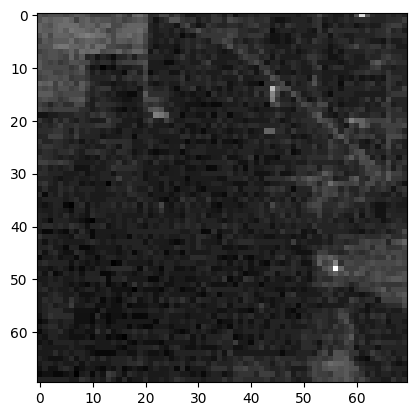

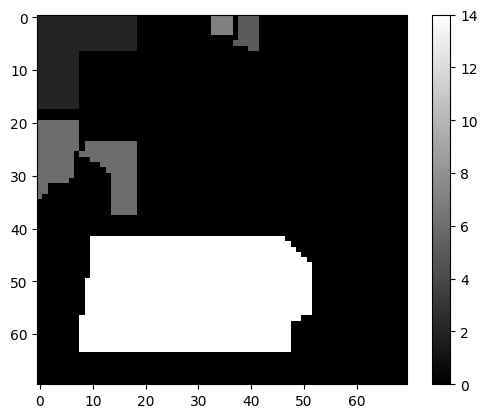

In [10]:
# patch_data, patch_labels, Aset = extract_patches(data, labels, 11, np.arange(16))

# D = patch_data[0]
# D.shape
plt.figure()
plt.imshow(data[-70:,-70:,2], cmap = 'grey')

plt.figure()
plt.imshow(labels[-70:,-70:], cmap = 'grey')
plt.colorbar()

In [11]:
np.where(labels!=0)

(array([  0,   0,   0, ..., 143, 143, 143]),
 array([ 0,  1,  2, ..., 30, 31, 32]))

In [12]:
D = np.reshape(data[:70,:70,:]/data[:70,:70,:].max(), (-1,200))

In [13]:
D.shape

(4900, 200)

In [14]:
n_2 = 100
p = 100
errs = []
flag_types = []
n1s = []
the_As = []
for n_1 in range(10,n_2-10,5): #loop through every feature combination between {1,2,...,n_1} \subset {1,...,220}
    As = [np.arange(n_1),  np.arange(100)]
    the_As.append(As)

    my_flag_rep = FlagRep(Aset = As)

    
    X = my_flag_rep.fit_transform(D[:,:n_2])
    D_out0 = my_flag_rep.inverse_transform(X)
    err0 = np.linalg.norm(D_out0[:,:n_2]-D[:,:n_2])**2
    errs.append(err0)

    if ~np.isclose(err0,0):
        print()
        print(np.array([n_1,n_2]))
        print(my_flag_rep.flag_type())
        print(err0)

    # U,_,_ = my_svd(D[:,:n_2], n_vecs = my_flag_rep.flag_type()[-1])
    # D_out1 = U[:,:my_flag_rep.flag_type()[-1]] @ U[:,:my_flag_rep.flag_type()[-1]].T @ D[:,:n_2]
    # err1 = np.linalg.norm(D_out1[:,:n_2] - D[:,:n_2])**2
    
    
    # if ~np.isclose(err0, 0) and np.abs(err0-err1) < 1000000:
    # print()
    # print(np.array([n_1,n_2]))
    # print(my_flag_rep.flag_type())
    # print(err0, err1)

    flag_types.append(my_flag_rep.flag_type())
    n1s.append(n_1)


[ 10 100]
[10 99]
0.00697684289675258

[ 20 100]
[20 99]
0.006977028111004313

[ 25 100]
[25 99]
0.006977072624747595

[ 35 100]
[34 98]
0.06609292779642753

[ 50 100]
[50 99]
0.006978341058600557

[ 55 100]
[54 99]
0.032762892026961345

[ 60 100]
[59 98]
0.021338785401731106

[ 70 100]
[70 99]
0.006993140674362546

[ 85 100]
[84 99]
0.011819532436486268


In [15]:

U,S,Vh = my_svd(D[:,:n_2])
D_out1 = U @ U.T @ D[:,:n_2]

In [16]:
n1s[np.argmin(errs)]

40

In [17]:
# np.sort(errs), 
np.sum(np.isclose(errs, 0))

np.int64(7)

In [18]:

U,S,Vh = my_svd(D[:,:n_2])
np.linalg.norm(D[:,:n_2] - U @ U.T @ D[:,:n_2])**2

np.float64(0.006975961577750164)

Text(0, 0.5, 'reconstruction error')

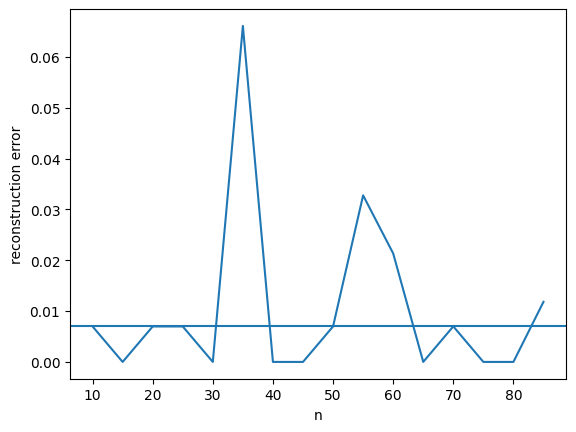

In [19]:
fig, ax = plt.subplots()
ax.plot(n1s, errs)
ax.axhline(np.linalg.norm(D_out1-D[:,:n_2])**2)
plt.xlabel('n')
plt.ylabel('reconstruction error')
# ax.set_yscale('log')

In [15]:
errs[-1], np.linalg.norm(D_out1-D[:,:n_2])**2

(np.float64(24089515415.602745), np.float64(4.295490191164382e-18))

# Try Weizmann data

In [17]:
import os
import cv2

from skimage.transform import rescale


def load_avi_files(directory):
    avi_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.avi'):
            avi_files.append(os.path.join(directory, filename))
    return avi_files


def read_avi_to_numpy(file_path, coarsen = .03):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    frame_array = np.array(frames)

    X = rescale(frame_array,(1,coarsen,coarsen))
    

    # Convert list of frames to a NumPy array
    return X


directory = '../data/weizmann/'  # Change to your directory

classes = ['bend', 'jack', 'run']


dataset = []
mod_labels = []
for class_name in classes:
    f_path = os.path.join(directory, class_name)
    avi_files = load_avi_files(f_path)
    data = [read_avi_to_numpy(avi_file, .03) for avi_file in avi_files]
    dataset += data
    mod_labels += [class_name]*len(data)

In [20]:
fewest_frame_count = np.min([len(d) for d in dataset])
_,n_rows, n_cols  = dataset[0].shape

trimmed_dataset = []
for d in dataset:
    n_frames = len(d)
    d_trimmed = d[n_frames//2-fewest_frame_count//2:n_frames//2+fewest_frame_count//2,:,:]
    trimmed_dataset.append(d_trimmed)

center_row = n_rows//2
center_col = n_cols//2

quarter_row = n_rows//4
quarter_col = n_cols//4

X = []
for d in trimmed_dataset:
    ss1 = d[:,n_rows//4:3*n_rows//4, n_cols//4:3*n_cols//4]
    ss2_mask = np.zeros((n_rows, n_cols), dtype=bool)
    # Set the outer pixels to True
    ss2_mask[:n_rows//4, :] = True  # Top
    ss2_mask[3*n_rows//4:, :] = True  # Bottom
    ss2_mask[:, :n_cols//4] = True  # Left
    ss2_mask[:, 3*n_cols//4+1:] = True  # Right

    
    # plt.axis('off')
    ss2 = d[:,ss2_mask]

    ss1 = ss1.reshape(ss1.shape[0], -1)
    ss2 = ss2.reshape(ss2.shape[0], -1)

    d_flat = np.hstack([ss1,ss2])


    X.append(d_flat)

ss_sizes = [ss1.shape[1], ss2.shape[1]]



In [22]:
As = [np.arange(len(ss1.T)), np.arange(len(ss1.T)+len(ss2.T))]

In [34]:
print(As)

[array([0, 1, 2, 3]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])]


In [35]:
D = X[6]

my_flagrep = FlagRep(Aset = As)
my_flag = my_flagrep.fit_transform(D)
D_out = my_flagrep.inverse_transform(my_flag)
print(my_flagrep.flag_type())

[ 4 18]


In [ ]:
my_flag

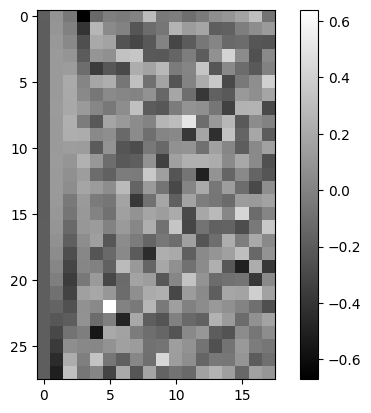

In [40]:
plt.imshow(my_flag, cmap = 'grey')
plt.colorbar()

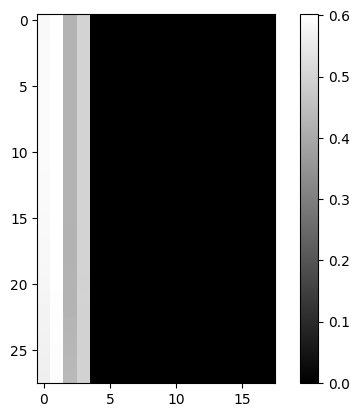

In [42]:

plt.imshow(D_out, cmap = 'grey')
plt.colorbar()